# Обучение языковой модели с помощью LSTM

Цель: построить генеративную языковую модель, которая по началу/теме предложения сможет генерировать осмысленный текст.
Основной задачей является экспериментирование с разными схемами моделей и параметрами, грамотная оценка качества модели через перплексию.

---

## 0. Зависимости.
Стандартные библиотеки для работы с текстом. Настройка MLflow для логирования экспериментов.

In [1]:
!pip install datasets
!pip install mlflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.7/17.7 MB 62.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.5/83.5 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 8.9 MB/s eta 0:00:00
  Created wheel for databricks-cli: filename=databricks_cli-0.17.7-py3-none-any.whl size=143882 sha256=85f8fbb38d9865ec51371c13cd501ae2e7697a6929ec789e83c0ae332a7008e5
  Stored in directory: /root/.cache/pip/wheels/ae/63/93/5402c1a09c1868a59d0b05013484e07af97a9d7b3dbd5bd39a
Successfully built databricks-cli


In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from datasets import load_dataset
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.model_selection import train_test_split
import nltk

from collections import Counter
from typing import List
import mlflow
import seaborn


#Секрет - адрес mlflow-сервера
from kaggle_secrets import UserSecretsClient

secret_value = UserSecretsClient().get_secret("mlflow_url")
mlflow.set_tracking_uri(secret_value)
seaborn.set(palette='summer')


In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device
nltk.download('punkt')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## 1. Подготовка данных.
Используется датасет imdb. В нем хранятся отзывы о фильмах с сайта imdb.

In [4]:
dataset = load_dataset('imdb')

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset imdb downloaded and prepared to /root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

## 2. Препроцессинг данных и создание словаря
Далее необходмо получить словарь или же просто set строк. Что необходимо сделать:

- Разделить отдельные тренировочные примеры на отдельные предложения с помощью функции sent_tokenize из бибилиотеки nltk. Каждое отдельное предложение будет одним тренировочным примером.
- Оставить только те предложения, в которых меньше word_threshold слов.
- Посчитать частоту вхождения каждого слова в оставшихся предложениях. Для деления предложения на отдельные слова удобно использовать функцию word_tokenize.
- Создать объект vocab класса set, положить в него служебные токены ```'<unk>', '<bos>', '<eos>', '<pad>'``` и vocab_size самых частовстречающихся слов.

In [5]:
# Первые два пункта
def filter_on_length(sentence: str, threshold=32):
    # Фильтруем по длине, отбрасывая длинные.
    word_count = len(word_tokenize(sentence))
    if word_count > threshold:
        return False
    return True

def get_sentences(data: Dataset, threshold=32) ->list:
    # Преобразуем датасет в список с предложениями
    sentences = []
    for review in tqdm(data["text"]):
        sentences +=[x.lower() for x in sent_tokenize(review) if filter_on_length(x, threshold)]
    return sentences

In [6]:
sentence_list = get_sentences(dataset["train"])
print(len(sentence_list))

  0%|          | 0/25000 [00:00<?, ?it/s]

202606


In [7]:
# Создание словаря
vocab = set(['<unk>', '<bos>', '<eos>', '<pad>'])
vocab_size = 40000

def count_words(sentences, size):
    word_dict = {}
    for sentence in tqdm(sentences):
        for word in Counter(word_tokenize(sentence)):
            if word in word_dict:
                word_dict[word] += 1
            else:
                word_dict[word] = 1
    word_dict = [key for key, _ in sorted(word_dict.items(), key=lambda item: item[1], reverse=True)]
    return word_dict[:size]

In [8]:
vocab.update(count_words(sentence_list, 40000))
assert '<unk>' in vocab
assert '<bos>' in vocab 
assert '<eos>' in vocab 
assert '<pad>' in vocab
assert len(vocab) == vocab_size + 4
print(len(vocab))

  0%|          | 0/202606 [00:00<?, ?it/s]

40004


## 3. Dataset и лоадеры.
Датасет с методом `__getitem__` и затем train- val- loaders

In [9]:
word2ind = {word: i for i, word in enumerate(vocab)}
ind2word = {i: word for word, i in word2ind.items()}

class WordDataset:
    def __init__(self, sentences):
        self.data = sentences
        # Маркеры неизв. слова, начала и конца предложения, паддинга.
        self.unk_id = word2ind['<unk>']
        self.bos_id = word2ind['<bos>']
        self.eos_id = word2ind['<eos>']
        self.pad_id = word2ind['<pad>']

    def __getitem__(self, idx: int) -> List[int]:
        # Предложения приведены к нижнему регистру, 
        # но не очищены от стоп-слов и пунктуации.
        tokenized_sentence = [self.bos_id]
        tokenized_sentence += [
            word2ind.get(word, self.unk_id) for word in word_tokenize(self.data[idx])
            ] 
        tokenized_sentence += [self.eos_id]

        return tokenized_sentence

    def __len__(self) -> int:
        return len(self.data)
    
def collate_fn_with_padding(
    input_batch: List[List[int]], pad_id=word2ind['<pad>']) -> torch.Tensor:
    # Паддинг: нужно выдавать entry одинаковой длины, соотв. заполняем нехват. строки
    seq_lens = [len(x) for x in input_batch]
    max_seq_len = max(seq_lens)

    new_batch = []
    for sequence in input_batch:
        for _ in range(max_seq_len - len(sequence)):
            sequence.append(pad_id)
        new_batch.append(sequence)
    
    sequences = torch.LongTensor(new_batch).to(device)

    new_batch = {
        'input_ids': sequences[:,:-1],
        'target_ids': sequences[:,1:]
    }

    return new_batch

In [10]:
train_sentences, eval_sentences = train_test_split(sentence_list, test_size=0.2)
eval_sentences, test_sentences = train_test_split(sentence_list, test_size=0.5)

train_dataset = WordDataset(train_sentences)
eval_dataset = WordDataset(eval_sentences)
test_dataset = WordDataset(test_sentences)

batch_size = 128

train_dataloader = DataLoader(
    train_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

eval_dataloader = DataLoader(
    eval_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

test_dataloader = DataLoader(
    test_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

## 4. Обучение и архитектура модели
---
Для обучения и логирования экспериментов понадобится функции train, evaluate, generate.
Train - стандартный, с логированием точности и лосса на обучающей и валидационной выборке + построением графиков.
Точность - из evaluate - перплексия = exp(CrossEntropy).

Экспериментальная часть подразумевает как перебор гиперпараметров, так и разные конфигурации моделей и нормализации.

In [11]:
def fit(train_dataloader, model, criterion, optimizer, epoch):
    epoch_losses = []
    model.train()
    for batch in tqdm(train_dataloader, desc=f'Training epoch {epoch}:'):
        optimizer.zero_grad()
        logits = model(batch['input_ids']).flatten(start_dim=0, end_dim=1)
        loss = criterion(
            logits, batch['target_ids'].flatten())
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
    return epoch_losses

def evaluate(model, criterion, dataloader) -> float:
    model.eval()
    perplexity = []
    with torch.no_grad():
        for batch in dataloader:
            logits = model(batch['input_ids']).flatten(start_dim=0, end_dim=1)
            loss = criterion(logits, batch['target_ids'].flatten())
            perplexity.append(torch.exp(loss).item())
    
    perplexity = sum(perplexity) / len(perplexity)

    return perplexity

def train(train_loader, eval_loader, model, criterion, optimizer, epochs=5):
    losses = []
    perplexities = []
    for epoch in range(epochs):
        epoch_losses = fit(train_loader, model, criterion, optimizer, epoch)
        losses.append(sum(epoch_losses) / len(epoch_losses))
        
        perplexities.append(evaluate(model, criterion, eval_loader))
    return losses, perplexities

In [12]:
def plot_results(losses, perplexity):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].plot(np.arange(len(losses)), losses)
    axes[0].set_title('Losses')
    axes[0].set_xlabel("epoch")
    axes[1].plot(np.arange(len(perplexity)), perplexity)
    axes[1].set_title('Accuracy on val.')
    plt.show()

In [13]:
class WordLM(nn.Module):
    def __init__(self, hidden_dim: int, vocab_size: int):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.GRU(hidden_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, vocab_size)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]
        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, seq_len, hidden_dim]
        projection = self.projection(self.non_lin(output))  # [batch_size, seq_len, vocab_size]

        return projection

In [29]:
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
first_model = WordLM(hidden_dim=128, vocab_size=len(vocab)).to(device)
optimizer = torch.optim.Adam(first_model.parameters())
losses, perp = train(train_dataloader, eval_dataloader, first_model, criterion, optimizer, epochs=15)

Training epoch 0::   0%|          | 0/1267 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/1267 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/1267 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/1267 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/1267 [00:00<?, ?it/s]

Training epoch 5::   0%|          | 0/1267 [00:00<?, ?it/s]

Training epoch 6::   0%|          | 0/1267 [00:00<?, ?it/s]

Training epoch 7::   0%|          | 0/1267 [00:00<?, ?it/s]

Training epoch 8::   0%|          | 0/1267 [00:00<?, ?it/s]

Training epoch 9::   0%|          | 0/1267 [00:00<?, ?it/s]

Training epoch 10::   0%|          | 0/1267 [00:00<?, ?it/s]

Training epoch 11::   0%|          | 0/1267 [00:00<?, ?it/s]

Training epoch 12::   0%|          | 0/1267 [00:00<?, ?it/s]

Training epoch 13::   0%|          | 0/1267 [00:00<?, ?it/s]

Training epoch 14::   0%|          | 0/1267 [00:00<?, ?it/s]

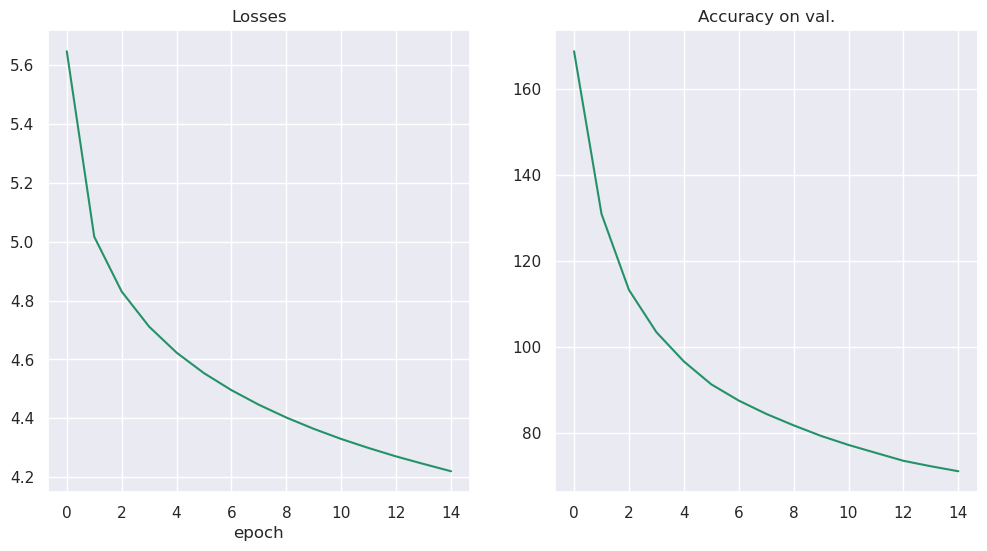

[168.69333573543665, 130.8990897843332, 113.23273095217618, 103.41924274328983, 96.6178619693024, 91.2939742887863, 87.52541989027851, 84.43428405125935, 81.76786549404414, 79.30967316001353, 77.21256469957757, 75.36380037635264, 73.53050719848787, 72.26180531761862, 71.1045971302071]


In [30]:
plot_results(losses, perp)
print(perp)

In [58]:
def generate(model, input_seq:str, length=30) -> str:
    device = 'cpu'
    model = model.to(device)
    input_ids = [word2ind['<bos>']] + [
        word2ind.get(word, word2ind['<unk>']) for word in word_tokenize(input_seq)]
    input_ids = torch.LongTensor(input_ids).to(device)
    
    model.eval()
    with torch.no_grad():
        for i in range(length):
            next_word_distribution = model(input_ids)[-1]
            # print(next_word_distribution.squeeze())
            next_word = next_word_distribution.squeeze().argmax()
            if next_word.item() == word2ind['<eos>']:
                next_word_distribution[next_word] = -1000
                next_word = next_word_distribution.squeeze().argmax()
            input_ids = torch.cat([input_ids, next_word.unsqueeze(0)])
    
    words = ' '.join([ind2word[idx.item()] for idx in input_ids])

    return words

In [64]:
print(generate(first_model, input_seq='the fox in the ashes'))


<bos> the fox in the ashes is the most important thing that i 've seen in the movie . ) . < br / > < br / > the movie is a good movie .
9590
